### Context

I've just opened a "PEA" account (Plan d'épargne en Actions) in my bank which is a tax-advantaged savings and investment plan designed to encourage long-term investment in the european stock market. So, I have started this project in order to build a profitable stocks portfolio for my personal interest.

I hope this project helps you !

### Librairies needed

In [1]:
#API Financial Data
import yfinance as yf

#For Data Treatment
from datetime import datetime as dt
from datetime import timedelta
import pandas as pd
import numpy as np
import itertools

#Machine Learning
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

#For Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

#Optimization
import cvxopt as opt
from cvxopt import blas, solvers

#Others
import warnings

warnings.filterwarnings('ignore')
sns.set_theme()

/Users/ayoub/opt/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


# I - Data retrievement

In [2]:
pd.ExcelFile("tickers.xlsx").sheet_names

['Stock', 'ETF', 'Future', 'Index', 'Mutual Fund', 'Currency', 'About']

#### Target Asset Parameter

In [3]:
targeted_asset = "Stock"

In [4]:
european_stocks = pd.read_excel("tickers.xlsx", sheet_name = targeted_asset)
european_stocks = european_stocks.rename(columns=european_stocks.iloc[2]).drop(index=[0, 1, 2]) 
columns_to_keep = [column for column in european_stocks.columns if type(column) == str] 
european_stocks = european_stocks[columns_to_keep]
european_stocks.head(10)

,Ticker,Name,Exchange,Category Name,Country
3,OEDV,"Osage Exploration and Development, Inc.",PNK,NaN,USA
4,AAPL,Apple Inc.,NMS,Electronic Equipment,USA
5,BAC,Bank of America Corporation,NYQ,Money Center Banks,USA
6,AMZN,"Amazon.com, Inc.",NMS,Catalog & Mail Order Houses,USA
7,T,AT&T Inc.,NYQ,Telecom Services - Domestic,USA
8,GOOG,Alphabet Inc.,NMS,Internet Information Providers,USA
9,MO,"Altria Group, Inc.",NYQ,Cigarettes,USA
10,DAL,"Delta Air Lines, Inc.",NYQ,Major Airlines,USA
11,AA,Alcoa Corporation,NYQ,Aluminum,USA
12,AXP,American Express Company,NYQ,Credit Services,USA


In [5]:
#Country
print(list(set(european_stocks["Country"].to_list())))

[nan, 'Denmark', 'Australia', 'USA', 'Germany', 'Taiwan', 'Belgium', 'Turkey', 'Indonesia', 'Canada', 'Italy', 'Greece', 'Ireland', 'Portugal', 'Russia', 'South Korea', 'Lithuania', 'Argentina', 'France', 'Mexico', 'United Kingdom', 'Sweden', 'Thailand', 'Estonia', 'Norway', 'Spain', 'Finland', 'Switzerland', 'New Zealand', 'China', 'Iceland', 'Singapore', 'Qatar', 'Brazil', 'Netherlands', 'Malaysia', 'Austria', 'Venezuela', 'Latvia', 'Hong Kong', 'India', 'Israel']


In [6]:
#Exchange
print(list(set(european_stocks["Exchange"].to_list())))

['NGM', nan, 'LSE', 'NSI', 'HKG', 'TAI', 'GER', 'SHH', 'CCS', 'ASE', 'BRU', 'TLO', 'HEL', 'KLS', 'STO', 'CNQ', 'ISE', 'DOH', 'BER', 'PAR', 'MCX', 'HAN', 'AMS', 'DUS', 'IOB', 'SHZ', 'TAL', 'RIS', 'HAM', 'VAN', 'SAO', 'TOR', 'MIL', 'CPH', 'OBB', 'VIE', 'TWO', 'PCX', 'JKT', 'BUE', 'IST', 'OSL', 'MAD', 'SES', 'NYQ', 'EBS', 'LIT', 'KOE', 'KSC', 'SET', 'TLV', 'ASX', 'MUN', 'MDD', 'BSE', 'MCE', 'STU', 'FRA', 'LIS', 'ENX', 'NZE', 'PNK', 'ATH', 'NCM', 'EUX', 'MEX', 'NMS', 'ICE']


Index Tickers

- "^FCHI"(CAC 40 --> France)
- "^GDAXI" (DAX --> Germany)
- "^FTSE" (FTSE --> GB)
- "^GSPC" (S&P --> US)

#### Targeted Market Parameter

In [7]:
countries = ["France"]
exchange = ["PAR"]
index_ticker = "^FCHI"
start_date = "2018-06-20"
end_date = "2023-06-20"
period = (dt.strptime(end_date, "%Y-%m-%d")-dt.strptime(start_date, "%Y-%m-%d")).days

## Stocks Data

In [8]:
european_stocks_s= european_stocks[european_stocks["Country"].isin(countries)].dropna(subset=["Category Name"])
if len(exchange) != 0:
    european_stocks_s = european_stocks[european_stocks["Exchange"].isin(exchange)].dropna(subset=["Category Name"])
european_stocks_s

,Ticker,Name,Exchange,Category Name,Country
789,AI.PA,"Air Liquide, société anonyme",PAR,Chemicals - Major Diversified,France
942,CS.PA,AXA SA,PAR,Property & Casualty Insurance,France
964,ALO.PA,Alstom SA,PAR,Diversified Machinery,France
972,AC.PA,Accor SA,PAR,Lodging,France
1119,AF.PA,Air France-KLM SA,PAR,Major Airlines,France
...,...,...,...,...,...
104007,RE.PA,Colas SA,PAR,General Contractors,France
104878,INFY.PA,Infosys Limited,PAR,Information Technology Services,France
105064,LIN.PA,Linedata Services S.A.,PAR,Technical & System Software,France
105173,MAN.PA,Manutan International SA,PAR,Business Services,France


#### Dataframe compiling all daily returns from all tickers in the european_stocks_tickers datframe

In [9]:
df_prices = pd.DataFrame()
i = 0
for ticker, name, category in zip(european_stocks_s["Ticker"], european_stocks_s["Name"], european_stocks_s["Category Name"]):
    data = yf.Ticker(ticker).history(start=start_date, end=end_date, period="1d")
    if i == 0:
        x = len(data)
        i += 1
    if data["Volume"].sum() > period*(10**5) and data["Close"].sum() > period*10 and len(data) == x:
        df_prices["{}/{}/{}".format(name, ticker, category)] = data["Close"]

ALEHT.PA: Period '1d' is invalid, must be one of ['1mo', '3mo', '6mo', 'ytd', '1y', '2y', '5y', '10y', 'max']
Got error from yahoo api for ticker SIPH.PA, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- SIPH.PA: No timezone found, symbol may be delisted
Got error from yahoo api for ticker ATA.PA, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- ATA.PA: No timezone found, symbol may be delisted
Got error from yahoo api for ticker ALT.PA, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- ALT.PA: No timezone found, symbol may be delisted
ZC.PA: Period '1d' is invalid, must be one of ['1mo', '3mo', '6mo', 'ytd', '1y', '2y', '5y', '10y', 'max']
EDF.PA: No data found, symbol may be delisted
Got error from yahoo api for ticker SMTPC.PA, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- SMTPC.PA: No timezone found, symbol may be delisted
FDR.PA:

Got error from yahoo api for ticker VLAP.PA, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- VLAP.PA: No timezone found, symbol may be delisted
Got error from yahoo api for ticker UFF.PA, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- UFF.PA: No timezone found, symbol may be delisted
UDIS.PA: Period '1d' is invalid, must be one of ['1mo', '3mo', '6mo', 'ytd', '1y', '2y', '5y', '10y', 'max']
Got error from yahoo api for ticker HSB.PA, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- HSB.PA: No timezone found, symbol may be delisted
Got error from yahoo api for ticker MSTY.PA, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- MSTY.PA: No timezone found, symbol may be delisted
Got error from yahoo api for ticker MLKRI.PA, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- MLKRI.PA: No timezone found, s

Got error from yahoo api for ticker LLY.PA, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- LLY.PA: No timezone found, symbol may be delisted
Got error from yahoo api for ticker STNT.PA, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- STNT.PA: No timezone found, symbol may be delisted
MLFRC.PA: Period '1d' is invalid, must be one of ['1mo', '3mo', '6mo', 'ytd', '1y', '2y', '5y', '10y', 'max']
Got error from yahoo api for ticker APR.PA, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- APR.PA: No timezone found, symbol may be delisted
MLART.PA: Period '1d' is invalid, must be one of ['1mo', '3mo', '6mo', 'ytd', '1y', '2y', '5y', '10y', 'max']
Got error from yahoo api for ticker JXR.PA, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- JXR.PA: No timezone found, symbol may be delisted
ASK.PA: Period '1d' is invalid, must be one of ['1mo',

Got error from yahoo api for ticker SO.PA, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- SO.PA: No timezone found, symbol may be delisted
Got error from yahoo api for ticker SFT.PA, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- SFT.PA: No timezone found, symbol may be delisted
Got error from yahoo api for ticker SFBS.PA, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- SFBS.PA: No timezone found, symbol may be delisted
Got error from yahoo api for ticker RIB.PA, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- RIB.PA: No timezone found, symbol may be delisted
RCF.PA: Period '1d' is invalid, must be one of ['1mo', '3mo', '6mo', 'ytd', '1y', '2y', '5y', '10y', 'max']
Got error from yahoo api for ticker PSB.PA, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- PSB.PA: No timezone found, symbol may

In [10]:
df_prices.index = df_prices.index.strftime('%Y-%m-%d')
df_prices

,"Air Liquide, société anonyme/AI.PA/Chemicals - Major Diversified",AXA SA/CS.PA/Property & Casualty Insurance,Alstom SA/ALO.PA/Diversified Machinery,Accor SA/AC.PA/Lodging,Atos SE/ATO.PA/Information Technology Services,BNP Paribas SA/BNP.PA/Money Center Banks,Danone/BN.PA/Food - Major Diversified,Bouygues SA/EN.PA/General Contractors,Compagnie Générale des Etablissements Michelin/ML.PA/Rubber & Plastics,Dassault Systèmes SE/DSY.PA/Technical & System Software,...,Avenir Telecom S.A./AVT.PA/Communication Equipment,SCOR SE/SCR.PA/Property & Casualty Insurance,Lagardère SCA/MMB.PA/Publishing - Newspapers,Legrand SA/LR.PA/Diversified Machinery,SPIE SAS/SPIE.PA/General Contractors,Rubis/RUI.PA/Gas Utilities,Korian/KORI.PA/Hospitals,Compagnie Plastic Omnium SA/POM.PA/Auto Parts,Klepierre SA/LI.PA/REIT - Retail,Worldline S.A./WLN.PA/Business Services
Date,,,,,,,,,,,,,,,,,,,,,
2018-06-20,80.664185,14.735512,33.656635,41.868549,88.492088,37.009636,52.338406,28.049761,23.286812,24.517529,...,2560.000000,20.425133,18.936766,56.969585,15.358505,45.067760,24.068342,34.769676,22.558805,52.349998
2018-06-21,80.328079,14.611828,33.444263,40.984676,88.565102,36.665039,52.248123,27.797598,22.966644,24.018766,...,2560.000000,20.483398,18.790220,56.662525,15.066776,44.453548,24.136236,33.695133,22.462841,51.950001
2018-06-22,81.299042,14.718335,33.512222,41.301723,89.258728,37.161255,53.142731,28.257427,23.126728,23.754721,...,2444.800049,20.735880,19.018179,57.186333,15.289860,43.609005,24.204128,33.878593,22.613646,52.799999
2018-06-25,79.693214,14.539680,33.129955,40.821354,86.703270,36.437603,51.985485,27.916258,22.827906,23.402653,...,2227.199951,20.263288,18.985615,56.102577,15.221220,42.956409,24.204128,32.830261,22.469694,49.580002
2018-06-26,79.170387,14.450354,33.053497,40.254524,86.630249,36.348015,51.747475,27.901426,22.753199,23.510229,...,2118.399902,20.282707,18.928625,55.867764,15.315601,42.994797,24.204128,32.725430,22.332602,48.700001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-13,158.860001,26.379999,27.414459,33.430000,13.800000,56.680000,53.840000,29.830000,27.900000,41.165001,...,0.173600,24.670000,21.900000,92.879997,29.580000,24.980000,7.083801,16.510000,21.271345,35.840000
2023-06-14,159.580002,26.655001,26.938892,33.509998,13.820000,57.520000,53.939999,30.120001,27.969999,40.875000,...,0.171600,24.650000,22.000000,92.559998,29.680000,24.940001,7.267295,16.969999,21.463758,35.700001
2023-06-15,160.300003,26.575001,26.205727,33.299999,13.755000,56.290001,54.660000,30.299999,27.629999,40.820000,...,0.172600,24.299999,21.549999,91.540001,29.240000,23.879999,7.252809,16.780001,21.396414,35.060001


In [11]:
df_returns = 100*df_prices.pct_change().dropna()
df_returns

,"Air Liquide, société anonyme/AI.PA/Chemicals - Major Diversified",AXA SA/CS.PA/Property & Casualty Insurance,Alstom SA/ALO.PA/Diversified Machinery,Accor SA/AC.PA/Lodging,Atos SE/ATO.PA/Information Technology Services,BNP Paribas SA/BNP.PA/Money Center Banks,Danone/BN.PA/Food - Major Diversified,Bouygues SA/EN.PA/General Contractors,Compagnie Générale des Etablissements Michelin/ML.PA/Rubber & Plastics,Dassault Systèmes SE/DSY.PA/Technical & System Software,...,Avenir Telecom S.A./AVT.PA/Communication Equipment,SCOR SE/SCR.PA/Property & Casualty Insurance,Lagardère SCA/MMB.PA/Publishing - Newspapers,Legrand SA/LR.PA/Diversified Machinery,SPIE SAS/SPIE.PA/General Contractors,Rubis/RUI.PA/Gas Utilities,Korian/KORI.PA/Hospitals,Compagnie Plastic Omnium SA/POM.PA/Auto Parts,Klepierre SA/LI.PA/REIT - Retail,Worldline S.A./WLN.PA/Business Services
Date,,,,,,,,,,,,,,,,,,,,,
2018-06-21,-0.416672,-0.839360,-0.630995,-2.111067,0.082508,-0.931100,-0.172497,-0.898984,-1.374888,-2.034308,...,0.000000,0.285265,-0.773867,-0.538990,-1.899462,-1.362863,0.282088,-3.090460,-0.425397,-0.764084
2018-06-22,1.208746,0.728912,0.203200,0.773575,0.783183,1.353376,1.712229,1.654205,0.697027,-1.099331,...,-4.499998,1.232615,1.213177,0.924434,1.480632,-1.899834,0.281287,0.544471,0.671351,1.636186
2018-06-25,-1.975211,-1.213830,-1.140679,-1.163074,-2.862978,-1.947329,-2.177618,-1.207362,-1.292108,-1.482097,...,-8.900527,-2.279100,-0.171227,-1.895130,-0.448923,-1.496470,0.000000,-3.094379,-0.636569,-6.098480
2018-06-26,-0.656050,-0.614360,-0.230782,-1.388562,-0.084219,-0.245867,-0.457840,-0.053129,-0.327262,0.459676,...,-4.885060,0.095832,-0.300173,-0.418543,0.620064,0.089363,0.000000,-0.319314,-0.610122,-1.774911
2018-06-27,0.518887,-0.380411,1.182223,-0.334130,-0.547830,0.208555,0.333071,-0.983506,-1.454017,1.580699,...,-13.897277,-0.031926,-0.086023,1.810541,-1.512599,-5.089289,0.210387,2.375852,-0.337629,1.190961
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-13,0.569761,0.571863,0.838195,1.487558,0.436684,0.443027,0.055749,-0.864075,1.454544,1.006011,...,1.877940,0.693878,-0.454547,2.088364,0.612246,1.215556,-1.278603,-0.060534,-0.270635,-0.278237
2023-06-14,0.453230,1.042462,-1.734730,0.239300,0.144924,1.482004,0.185733,0.972179,0.250895,-0.704484,...,-1.152076,-0.081072,0.456623,-0.344530,0.338068,-0.160124,2.590327,2.786185,0.904566,-0.390623
2023-06-15,0.451185,-0.300131,-2.721588,-0.626676,-0.470330,-2.138386,1.334819,0.597604,-1.215589,-0.134557,...,0.582752,-1.419880,-2.045458,-1.101984,-1.482482,-4.250206,-0.199336,-1.119615,-0.313760,-1.792715


## Risk free Rate Data ("OAT" French Bunds)

In [12]:
risk_free_rate_data = pd.read_csv("oat_rates.csv", delimiter=";")
risk_free_rate_data = risk_free_rate_data.set_index(risk_free_rate_data["Titre :"]).drop(columns=["Titre :"])
risk_free_rate_data.index.name = "Date"
risk_free_rate_data = risk_free_rate_data.drop(index=["Code série :", "Unité :", "Magnitude :", "Méthode d'observation :", "Source :"])
risk_free_rate_data.index = pd.to_datetime(risk_free_rate_data.index, dayfirst=True)
risk_free_rate_data = risk_free_rate_data[risk_free_rate_data[risk_free_rate_data.columns] != "-"].loc[start_date:end_date].dropna()
risk_free_rate_data

,Emprunt Phare 10 ans,Taux indicatifs des bons du trésor à 1 mois,Taux indicatifs des bons du trésor à 12 mois,taux indicatifs des OAT 2 ans,Taux de l'OAT à 30 ans - France,Taux indicatifs des bons du trésor à 3 mois,taux indicatifs des OAT 5 ans,Taux indicatifs des bons du trésor à 6 mois,Taux indicatifs des bons du trésor à 9 mois
Date,,,,,,,,,
2023-06-20,"2,927","3,178","3,632","3,216","3,332","3,4","2,833","3,523","3,588"
2023-06-19,"3,032","3,19","3,628","3,282","3,446","3,412","2,928","3,549","3,608"
2023-06-16,"2,969","3,2","3,591","3,223","3,378","3,357","2,887","3,524","3,577"
2023-06-15,"3,017","3,167","3,573","3,264","3,439","3,347","2,918","3,499","3,554"
2023-06-14,"2,971","3,179","3,48","3,123","3,452","3,318","2,825","3,449","3,488"
...,...,...,...,...,...,...,...,...,...
2018-06-26,"0,735","-0,702","-0,582","-0,451","1,703","-0,619","0,051","-0,609","-0,603"
2018-06-25,"0,712","-0,685","-0,6","-0,464","1,682","-0,623","0,026","-0,61","-0,614"
2018-06-22,"0,706","-0,687","-0,608","-0,569","1,672","-0,609","-0,159","-0,609","-0,6"


In [13]:
risk_free_rate_data = risk_free_rate_data[["Taux indicatifs des bons du trésor à 1 mois","Taux indicatifs des bons du trésor à 3 mois","Taux indicatifs des bons du trésor à 6 mois","Taux indicatifs des bons du trésor à 9 mois","Taux indicatifs des bons du trésor à 12 mois","taux indicatifs des OAT 2 ans","taux indicatifs des OAT 5 ans","Emprunt Phare 10 ans","Taux de l'OAT à 30 ans - France"]]
risk_free_rate_data.loc["2023-04-25"]

Taux indicatifs des bons du trésor à 1 mois     2,808
Taux indicatifs des bons du trésor à 3 mois     3,066
Taux indicatifs des bons du trésor à 6 mois      3,23
Taux indicatifs des bons du trésor à 9 mois     3,232
Taux indicatifs des bons du trésor à 12 mois    3,319
taux indicatifs des OAT 2 ans                   2,936
taux indicatifs des OAT 5 ans                   2,739
Emprunt Phare 10 ans                            2,941
Taux de l'OAT à 30 ans - France                 3,355
Name: 2023-04-25 00:00:00, dtype: object

#### Example of a raw rate curve

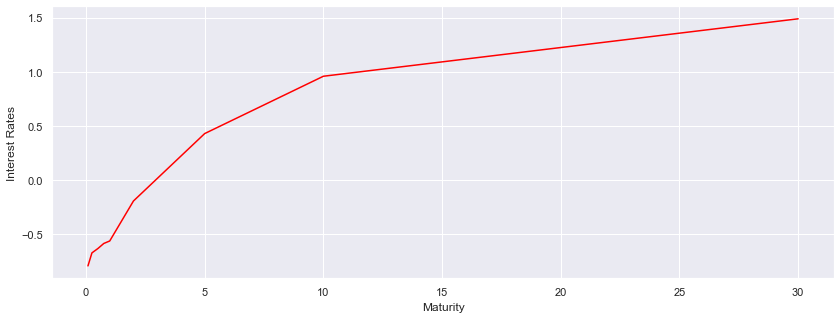

In [14]:
plt.figure(figsize=(14,5))
real_buckets = [round(1/12, 3), round(3/12, 3), round(6/12, 3), round(9/12, 3), 1.0, 2.0, 5.0, 10.0, 30.0]
rates_test = [float(elem.replace(",", ".")) for elem in risk_free_rate_data.loc["2022-03-22"]]
plt.plot(real_buckets, rates_test, color="red")
plt.xlabel("Maturity")
plt.ylabel("Interest Rates")
plt.show()

In [15]:
#Missing bucket (~weekly period) and construction of daily OAT curve by a linear interpolation
target_buckets = [round(i/52, 3) for i in range((30*52)+1)]
rates_curves = []
for date in risk_free_rate_data.index:
    rates_data = risk_free_rate_data.loc[date].to_list()
    rates_curves_daily = [float(rates_data[0].replace(",", "."))]
    moving_real_buckets = real_buckets.copy()
    for target_bucket in target_buckets:
        if round(target_bucket, 3) in real_buckets:
            rates_curves_daily.append(float(rates_data[real_buckets.index(round(target_bucket, 3))].replace(",", ".")))
        else:
            for real_bucket in moving_real_buckets:
                if target_bucket < real_bucket:
                    x_b, y_b = real_bucket, float(rates_data[real_buckets.index(real_bucket)].replace(",", "."))
                    x_a, y_a = real_buckets[real_buckets.index(real_bucket)-1], float(rates_data[real_buckets.index(real_bucket)-1].replace(",", "."))
                    inter_rate = ((x_b-target_bucket)/(x_b-x_a))*y_a + ((target_bucket-x_a)/(x_b-x_a))*y_b
                    rates_curves_daily.append(inter_rate)
                    moving_real_buckets.insert(moving_real_buckets.index(real_bucket), target_bucket)
                    break
    rates_curves.append([date] + rates_curves_daily[2:])

In [16]:
col_names = ["Date"] + ["OAT {} year(s)".format(bucket) for bucket in target_buckets[1:]]
data_rates = pd.DataFrame(rates_curves)
data_rates.columns = col_names
data_rates = data_rates.set_index(data_rates["Date"]).drop(columns=["Date"])
data_rates.index = data_rates.index.strftime("%Y-%m-%d")
data_rates

,OAT 0.019 year(s),OAT 0.038 year(s),OAT 0.058 year(s),OAT 0.077 year(s),OAT 0.096 year(s),OAT 0.115 year(s),OAT 0.135 year(s),OAT 0.154 year(s),OAT 0.173 year(s),OAT 0.192 year(s),...,OAT 29.827 year(s),OAT 29.846 year(s),OAT 29.865 year(s),OAT 29.885 year(s),OAT 29.904 year(s),OAT 29.923 year(s),OAT 29.942 year(s),OAT 29.962 year(s),OAT 29.981 year(s),OAT 30.0 year(s)
Date,,,,,,,,,,,,,,,,,,,,,
2023-06-20,3.177671,3.177768,3.177871,3.177969,3.195281,3.220539,3.247126,3.272383,3.297641,3.322898,...,3.328497,3.328882,3.329266,3.329671,3.330056,3.330441,3.330825,3.331230,3.331615,3.332
2023-06-19,3.189452,3.189615,3.189786,3.189949,3.207281,3.232539,3.259126,3.284383,3.309641,3.334898,...,3.442419,3.442812,3.443206,3.443620,3.444013,3.444406,3.444799,3.445213,3.445607,3.446
2023-06-16,3.199619,3.199732,3.199851,3.199964,3.212222,3.230084,3.248886,3.266749,3.284611,3.302473,...,3.374462,3.374851,3.375239,3.375648,3.376037,3.376425,3.376814,3.377223,3.377611,3.378
2023-06-15,3.166418,3.166591,3.166773,3.166945,3.181012,3.201491,3.223048,3.243527,3.264006,3.284485,...,3.435350,3.435751,3.436152,3.436574,3.436974,3.437375,3.437776,3.438198,3.438599,3.439
2023-06-14,3.178416,3.178589,3.178772,3.178945,3.189820,3.205635,3.222281,3.238096,3.253910,3.269725,...,3.447839,3.448296,3.448753,3.449234,3.449691,3.450148,3.450605,3.451086,3.451543,3.452
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-06-26,-0.707145,-0.705618,-0.704010,-0.702482,-0.695539,-0.686096,-0.676156,-0.666713,-0.657269,-0.647826,...,1.694627,1.695546,1.696466,1.697434,1.698354,1.699273,1.700193,1.701161,1.702080,1.703
2018-06-25,-0.690064,-0.688560,-0.686978,-0.685475,-0.680174,-0.673120,-0.665695,-0.658641,-0.651587,-0.644533,...,1.673609,1.674531,1.675453,1.676423,1.677344,1.678265,1.679187,1.680157,1.681078,1.682
2018-06-22,-0.692046,-0.690548,-0.688971,-0.687473,-0.680928,-0.672054,-0.662713,-0.653838,-0.644964,-0.636090,...,1.663644,1.664562,1.665479,1.666446,1.667363,1.668281,1.669199,1.670165,1.671082,1.672


#### Exemple of a rate curve after linear interpolations

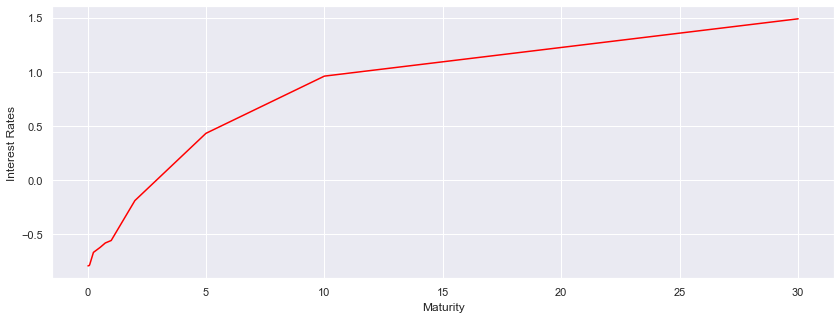

In [17]:
plt.figure(figsize=(14,5))
plt.plot(target_buckets[1:], data_rates.loc["2022-03-22"], color="red")
plt.xlabel("Maturity")
plt.ylabel("Interest Rates")
plt.show()

In [18]:
print(period/365)
for target in target_buckets:
    if target > (period/365) and (abs(target - (period/365)) < abs(target_buckets[target_buckets.index(target)-1]-(period/365))):
        index_t = target_buckets.index(target)
        break
    elif target > (period/365) and (abs(target - (period/365)) > abs(target_buckets[target_buckets.index(target)-1]-(period/365))):
        index_t = target_buckets.index(target)-1
        break
index_t

5.002739726027397


260

In [19]:
data_rates.iloc[:, index_t]

Date
2023-06-20    2.833357
2023-06-19    2.928395
2023-06-16    2.887312
2023-06-15    2.918376
2023-06-14    2.825555
                ...   
2018-06-26    0.053599
2018-06-25    0.028607
2018-06-22   -0.155713
2018-06-21   -0.162690
2018-06-20   -0.142736
Name: OAT 5.019 year(s), Length: 1258, dtype: float64

## Final DataFrame

In [20]:
available_dates = [date for date in df_returns.index if date in data_rates.index]
df_returns = df_returns[df_returns.index.isin(available_dates)]
df_returns.insert(len(df_returns.columns), "Rates", data_rates.iloc[:, index_t])
df_returns

,"Air Liquide, société anonyme/AI.PA/Chemicals - Major Diversified",AXA SA/CS.PA/Property & Casualty Insurance,Alstom SA/ALO.PA/Diversified Machinery,Accor SA/AC.PA/Lodging,Atos SE/ATO.PA/Information Technology Services,BNP Paribas SA/BNP.PA/Money Center Banks,Danone/BN.PA/Food - Major Diversified,Bouygues SA/EN.PA/General Contractors,Compagnie Générale des Etablissements Michelin/ML.PA/Rubber & Plastics,Dassault Systèmes SE/DSY.PA/Technical & System Software,...,SCOR SE/SCR.PA/Property & Casualty Insurance,Lagardère SCA/MMB.PA/Publishing - Newspapers,Legrand SA/LR.PA/Diversified Machinery,SPIE SAS/SPIE.PA/General Contractors,Rubis/RUI.PA/Gas Utilities,Korian/KORI.PA/Hospitals,Compagnie Plastic Omnium SA/POM.PA/Auto Parts,Klepierre SA/LI.PA/REIT - Retail,Worldline S.A./WLN.PA/Business Services,Rates
Date,,,,,,,,,,,,,,,,,,,,,
2018-06-21,-0.416672,-0.839360,-0.630995,-2.111067,0.082508,-0.931100,-0.172497,-0.898984,-1.374888,-2.034308,...,0.285265,-0.773867,-0.538990,-1.899462,-1.362863,0.282088,-3.090460,-0.425397,-0.764084,-0.162690
2018-06-22,1.208746,0.728912,0.203200,0.773575,0.783183,1.353376,1.712229,1.654205,0.697027,-1.099331,...,1.232615,1.213177,0.924434,1.480632,-1.899834,0.281287,0.544471,0.671351,1.636186,-0.155713
2018-06-25,-1.975211,-1.213830,-1.140679,-1.163074,-2.862978,-1.947329,-2.177618,-1.207362,-1.292108,-1.482097,...,-2.279100,-0.171227,-1.895130,-0.448923,-1.496470,0.000000,-3.094379,-0.636569,-6.098480,0.028607
2018-06-26,-0.656050,-0.614360,-0.230782,-1.388562,-0.084219,-0.245867,-0.457840,-0.053129,-0.327262,0.459676,...,0.095832,-0.300173,-0.418543,0.620064,0.089363,0.000000,-0.319314,-0.610122,-1.774911,0.053599
2018-06-27,0.518887,-0.380411,1.182223,-0.334130,-0.547830,0.208555,0.333071,-0.983506,-1.454017,1.580699,...,-0.031926,-0.086023,1.810541,-1.512599,-5.089289,0.210387,2.375852,-0.337629,1.190961,0.038580
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-13,0.569761,0.571863,0.838195,1.487558,0.436684,0.443027,0.055749,-0.864075,1.454544,1.006011,...,0.693878,-0.454547,2.088364,0.612246,1.215556,-1.278603,-0.060534,-0.270635,-0.278237,2.808547
2023-06-14,0.453230,1.042462,-1.734730,0.239300,0.144924,1.482004,0.185733,0.972179,0.250895,-0.704484,...,-0.081072,0.456623,-0.344530,0.338068,-0.160124,2.590327,2.786185,0.904566,-0.390623,2.825555
2023-06-15,0.451185,-0.300131,-2.721588,-0.626676,-0.470330,-2.138386,1.334819,0.597604,-1.215589,-0.134557,...,-1.419880,-2.045458,-1.101984,-1.482482,-4.250206,-0.199336,-1.119615,-0.313760,-1.792715,2.918376


# II - Individual Stocks Assessment

In [21]:
df_r = df_returns.copy()

In [22]:
#Stocks "Name/Yahoo_Symbol/Category"
L = [stock for stock in df_returns.columns if "/" in stock]
L

['Air Liquide, société anonyme/AI.PA/Chemicals - Major Diversified',
 'AXA SA/CS.PA/Property & Casualty Insurance',
 'Alstom SA/ALO.PA/Diversified Machinery',
 'Accor SA/AC.PA/Lodging',
 'Atos SE/ATO.PA/Information Technology Services',
 'BNP Paribas SA/BNP.PA/Money Center Banks',
 'Danone/BN.PA/Food - Major Diversified',
 'Bouygues SA/EN.PA/General Contractors',
 'Compagnie Générale des Etablissements Michelin/ML.PA/Rubber & Plastics',
 'Dassault Systèmes SE/DSY.PA/Technical & System Software',
 'Eurofins Scientific SE/ERF.PA/Medical Laboratories & Research',
 'Faurecia S.A./EO.PA/Auto Parts',
 'Schneider Electric S.E./SU.PA/Diversified Machinery',
 'Veolia Environnement S.A./VIE.PA/Waste Management',
 'Ubisoft Entertainment SA/UBI.PA/Multimedia & Graphics Software',
 'Eiffage SA/FGR.PA/General Contractors',
 'Edenred SA/EDEN.PA/Credit Services',
 'Publicis Groupe S.A./PUB.PA/Advertising Agencies',
 "L'Oréal S.A./OR.PA/Personal Products",
 'Sanofi/SAN.PA/Drug Manufacturers - Major',
 

### Start with an example to illustrate the procedure

In [23]:
#Choose your stock
stock = L[0]

In [24]:
data = yf.Ticker(stock.split("/")[1]).history(start=start_date, end=end_date, period="1d")
data.index = data.index.strftime('%Y-%m-%d')
data

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2018-06-20,81.224345,81.597790,80.664177,80.664177,889452,0.0,0.0
2018-06-21,81.149649,81.448401,79.991969,80.328072,917426,0.0,0.0
2018-06-22,80.701523,81.299034,80.477450,81.299034,946310,0.0,0.0
2018-06-25,80.925595,81.224347,79.543843,79.693222,719283,0.0,0.0
2018-06-26,79.730571,80.029330,79.170403,79.170403,793465,0.0,0.0
...,...,...,...,...,...,...,...
2023-06-13,158.500000,159.440002,157.320007,158.860001,604136,0.0,0.0
2023-06-14,158.660004,160.279999,158.460007,159.580002,540877,0.0,0.0
2023-06-15,159.320007,160.479996,158.960007,160.300003,422036,0.0,0.0


In [25]:
#Global variable for ratios
return_period = np.divide(100*(np.array(data["Close"].diff().dropna()) + np.array(data["Dividends"][1:])), np.array(data["Close"].to_list()[:-1]))
av_return_period = return_period.mean() * 252
risk_free_rate = df_returns["Rates"].loc[data.index[1]]
stock_vol = round(return_period.std(), 2) * np.sqrt(252)

#### Sharpe Ratio

In [26]:
sharpe_ratio = (av_return_period-risk_free_rate)/stock_vol
print("Ratio de Sharpe: ", sharpe_ratio)

Ratio de Sharpe:  0.8551816117142919


#### Sortino Ratio

In [27]:
neg_return = [return_ for return_ in return_period if return_ < 0]
if len(neg_return) > 1:
    stock_vol_sortino = np.std(neg_return) * np.sqrt(252)
    sortino_ratio = (av_return_period - risk_free_rate)/stock_vol_sortino
else:
    sortino_ratio = 0
print("Ratio de Sortino: ", sortino_ratio)

Ratio de Sortino:  1.1614981551872372


#### Benchmark Index

In [28]:
start_date_index = dt.strptime(df_returns.index[0], "%Y-%m-%d") - timedelta(days=30)
end_date_index = dt.strptime(df_returns.index[0], "%Y-%m-%d") + timedelta(days=30)
index_ref = yf.Ticker(index_ticker).history(start=start_date_index, end=end_date, period="1d")
index_ref.index = index_ref.index.strftime("%Y-%m-%d")

In [29]:
index_returns = pd.DataFrame(np.divide(100*(np.array(index_ref["Close"].diff().dropna()) + np.array(index_ref["Dividends"][1:])), np.array(index_ref["Close"].to_list()[:-1])), \
                             index= index_ref.index[1:], columns=["Index Returns"])

In [30]:
if "Index Returns" in df_r.columns:  
    del df_r["Index Returns"]
df_r.insert(len(df_returns.columns)-1, "Index Returns", index_returns[index_returns.index.isin(df_r.index)], True)

In [31]:
#Who outperforms ? 
if sum(np.array(df_r[stock])-np.array(df_r["Index Returns"])) > 0:
    print("L'action de {} a surperformé l'indice !!".format(stock.split("/")[0]))
else:
    print("L'indice a surperformé l'action de {}".format(stock.split("/")[0]))

L'action de Air Liquide, société anonyme a surperformé l'indice !!


In [32]:
df_r = df_r.dropna()
df_r

,"Air Liquide, société anonyme/AI.PA/Chemicals - Major Diversified",AXA SA/CS.PA/Property & Casualty Insurance,Alstom SA/ALO.PA/Diversified Machinery,Accor SA/AC.PA/Lodging,Atos SE/ATO.PA/Information Technology Services,BNP Paribas SA/BNP.PA/Money Center Banks,Danone/BN.PA/Food - Major Diversified,Bouygues SA/EN.PA/General Contractors,Compagnie Générale des Etablissements Michelin/ML.PA/Rubber & Plastics,Dassault Systèmes SE/DSY.PA/Technical & System Software,...,Lagardère SCA/MMB.PA/Publishing - Newspapers,Legrand SA/LR.PA/Diversified Machinery,SPIE SAS/SPIE.PA/General Contractors,Rubis/RUI.PA/Gas Utilities,Korian/KORI.PA/Hospitals,Compagnie Plastic Omnium SA/POM.PA/Auto Parts,Klepierre SA/LI.PA/REIT - Retail,Worldline S.A./WLN.PA/Business Services,Index Returns,Rates
Date,,,,,,,,,,,,,,,,,,,,,
2018-06-21,-0.416672,-0.839360,-0.630995,-2.111067,0.082508,-0.931100,-0.172497,-0.898984,-1.374888,-2.034308,...,-0.773867,-0.538990,-1.899462,-1.362863,0.282088,-3.090460,-0.425397,-0.764084,-1.047972,-0.162690
2018-06-22,1.208746,0.728912,0.203200,0.773575,0.783183,1.353376,1.712229,1.654205,0.697027,-1.099331,...,1.213177,0.924434,1.480632,-1.899834,0.281287,0.544471,0.671351,1.636186,1.342551,-0.155713
2018-06-25,-1.975211,-1.213830,-1.140679,-1.163074,-2.862978,-1.947329,-2.177618,-1.207362,-1.292108,-1.482097,...,-0.171227,-1.895130,-0.448923,-1.496470,0.000000,-3.094379,-0.636569,-6.098480,-1.921528,0.028607
2018-06-26,-0.656050,-0.614360,-0.230782,-1.388562,-0.084219,-0.245867,-0.457840,-0.053129,-0.327262,0.459676,...,-0.300173,-0.418543,0.620064,0.089363,0.000000,-0.319314,-0.610122,-1.774911,-0.048635,0.053599
2018-06-27,0.518887,-0.380411,1.182223,-0.334130,-0.547830,0.208555,0.333071,-0.983506,-1.454017,1.580699,...,-0.086023,1.810541,-1.512599,-5.089289,0.210387,2.375852,-0.337629,1.190961,0.869298,0.038580
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-13,0.569761,0.571863,0.838195,1.487558,0.436684,0.443027,0.055749,-0.864075,1.454544,1.006011,...,-0.454547,2.088364,0.612246,1.215556,-1.278603,-0.060534,-0.270635,-0.278237,0.557900,2.808547
2023-06-14,0.453230,1.042462,-1.734730,0.239300,0.144924,1.482004,0.185733,0.972179,0.250895,-0.704484,...,0.456623,-0.344530,0.338068,-0.160124,2.590327,2.786185,0.904566,-0.390623,0.517501,2.825555
2023-06-15,0.451185,-0.300131,-2.721588,-0.626676,-0.470330,-2.138386,1.334819,0.597604,-1.215589,-0.134557,...,-2.045458,-1.101984,-1.482482,-4.250206,-0.199336,-1.119615,-0.313760,-1.792715,-0.513331,2.918376


#### Treynor Ratio

##### Deals with outliers by the IQR method

In [33]:
#Deals with outliers BY the IQR method
outliers_index_by_stock = []
i = 0
df_o = df_r.copy()
for col in df_o.columns[:-2]:
    Q1 = df_o[col].quantile(0.25)
    Q3 = df_o[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_whisker = Q1 - 1.5*IQR
    upper_whisker = Q3 + 1.5*IQR
    outliers_index_by_stock.append([col, list(df_o[(df_o[col] >= upper_whisker) | (df_o[col] <= lower_whisker)][col].index)])

In [34]:
max_len_outliers = len(max(outliers_index_by_stock, key=lambda x: len(x[1]))[1])
max_len_outliers

170

In [35]:
for outlier in outliers_index_by_stock:
    n = len(outlier[1])
    if n < max_len_outliers:
        outlier[1] = outlier[1] + [np.nan]*(max_len_outliers-n)

In [36]:
df_outliers = pd.DataFrame()
i = 0 
for outlier in outliers_index_by_stock:
    df_outliers.insert(i, outlier[0], outlier[1])
df_outliers

,Worldline S.A./WLN.PA/Business Services,Klepierre SA/LI.PA/REIT - Retail,Compagnie Plastic Omnium SA/POM.PA/Auto Parts,Korian/KORI.PA/Hospitals,Rubis/RUI.PA/Gas Utilities,SPIE SAS/SPIE.PA/General Contractors,Legrand SA/LR.PA/Diversified Machinery,Lagardère SCA/MMB.PA/Publishing - Newspapers,SCOR SE/SCR.PA/Property & Casualty Insurance,Avenir Telecom S.A./AVT.PA/Communication Equipment,...,Dassault Systèmes SE/DSY.PA/Technical & System Software,Compagnie Générale des Etablissements Michelin/ML.PA/Rubber & Plastics,Bouygues SA/EN.PA/General Contractors,Danone/BN.PA/Food - Major Diversified,BNP Paribas SA/BNP.PA/Money Center Banks,Atos SE/ATO.PA/Information Technology Services,Accor SA/AC.PA/Lodging,Alstom SA/ALO.PA/Diversified Machinery,AXA SA/CS.PA/Property & Casualty Insurance,"Air Liquide, société anonyme/AI.PA/Chemicals - Major Diversified"
0,2018-06-25,2019-06-06,2018-11-02,2018-09-13,2018-06-27,2018-07-11,2018-11-08,2018-07-27,2018-08-17,2018-06-27,...,2018-09-05,2018-08-22,2018-08-30,2018-07-27,2019-01-04,2018-07-23,2019-06-18,2018-12-21,2018-10-11,2018-10-10
1,2018-09-05,2020-03-09,2018-12-10,2019-01-10,2018-07-17,2018-07-27,2019-02-14,2018-11-08,2018-09-04,2018-06-29,...,2018-10-05,2018-10-10,2018-10-19,2018-10-17,2019-10-11,2018-08-07,2019-07-12,2019-01-25,2018-12-06,2019-08-02
2,2018-10-03,2020-03-12,2018-12-13,2019-04-01,2018-09-13,2018-10-19,2019-05-02,2018-12-10,2018-12-06,2018-07-18,...,2018-10-10,2018-10-19,2018-12-06,2018-11-09,2020-02-25,2018-10-23,2020-02-24,2019-09-12,2019-01-04,2019-08-14
3,2018-10-08,2020-03-16,2018-12-14,2019-06-21,2018-09-17,2018-11-08,2020-02-13,2019-03-14,2019-01-29,2018-09-13,...,2018-10-16,2018-10-29,2018-12-07,2019-08-02,2020-02-27,2018-10-24,2020-03-09,2020-02-18,2019-08-02,2019-10-02
4,2018-10-25,2020-03-19,2019-01-09,2020-03-06,2018-10-24,2018-11-15,2020-02-27,2019-11-06,2019-04-29,2018-11-23,...,2018-10-23,2018-11-27,2018-12-20,2019-10-18,2020-03-06,2018-12-06,2020-03-12,2020-03-12,2019-10-11,2019-12-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
166,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
167,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
168,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##### Linear Regression (Index Returns, Stock Returns)

In [37]:
reg_dict = {}
for col in df_outliers.columns:
    df_reg = pd.DataFrame()
    l_o = [elem for elem in df_outliers[col] if type(elem) == str]
    df_reg.insert(0, col + " Returns", df_r[~df_r.index.isin(l_o)][col])
    df_reg.insert(1, "Index Returns", df_r[~df_r.index.isin(l_o)]["Index Returns"])
    df_reg.insert(2, "Rates", df_r[~df_r.index.isin(l_o)]["Rates"])
    reg_dict[col] = df_reg

In [38]:
kik = reg_dict[stock].columns
reg_dict[stock]

,"Air Liquide, société anonyme/AI.PA/Chemicals - Major Diversified Returns",Index Returns,Rates
Date,,,
2018-06-21,-0.416672,-1.047972,-0.162690
2018-06-22,1.208746,1.342551,-0.155713
2018-06-25,-1.975211,-1.921528,0.028607
2018-06-26,-0.656050,-0.048635,0.053599
2018-06-27,0.518887,0.869298,0.038580
...,...,...,...
2023-06-09,-0.063810,-0.124752,2.765616
2023-06-12,0.868455,0.515864,2.743635
2023-06-13,0.569761,0.557900,2.808547


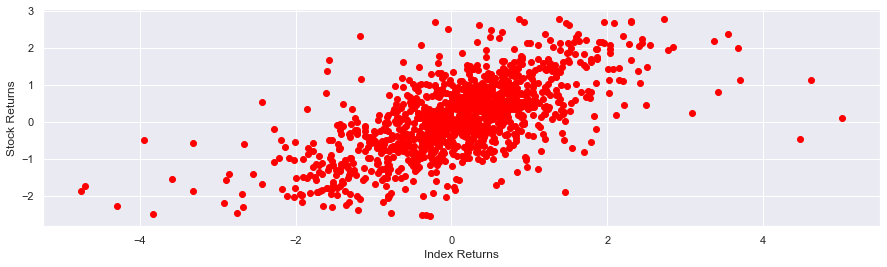

In [39]:
plt.figure(figsize=(15, 4))
plt.scatter(reg_dict[stock]["Index Returns"], reg_dict[stock]["{} Returns".format(stock)], color="red")
plt.xlabel("Index Returns")
plt.ylabel("Stock Returns")
plt.show()

In [40]:
#Scikit learn method
model = LinearRegression()
X, y = np.array(reg_dict[stock]["Index Returns"]), np.array(reg_dict[stock]["{} Returns".format(stock)])
X = X.reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
reg = model.fit(X_train, y_train)

In [41]:
r_sq = reg.score(X, y)
print('coefficient of determination:', r_sq)

print('Intercept:', reg.intercept_)

print('Slope:', reg.coef_) 

y_pred = reg.predict(X)

coefficient of determination: 0.4116513000949946
Intercept: 0.026373688518273576
Slope: [0.60889428]


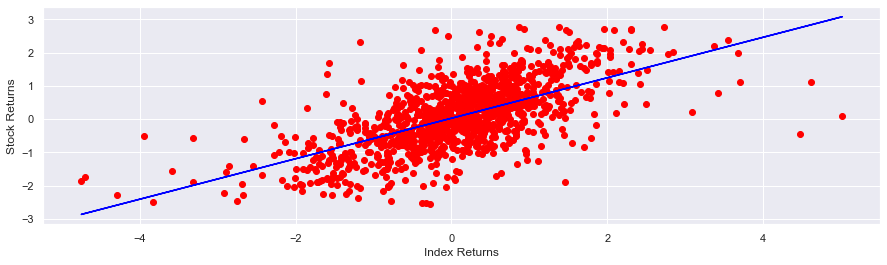

In [42]:
plt.figure(figsize=(15, 4))
plt.scatter(reg_dict[stock]["Index Returns"], reg_dict[stock]["{} Returns".format(stock)], color="red")
plt.plot(reg_dict[stock]["Index Returns"], y_pred, color="blue")
plt.xlabel("Index Returns")
plt.ylabel("Stock Returns")
plt.show()

In [43]:
beta = reg.coef_[0]
print("Treynor Ratio: ", ((av_return_period/252)-risk_free_rate)/beta)

Treynor Ratio:  0.384684594656811


### Now Let's apply the procedure to all stocks !

In [44]:
#Reminder
print(f"Period: {start_date} ==> {end_date}")

Period: 2018-06-20 ==> 2023-06-20


In [45]:
df_stocks_perf = pd.DataFrame(index=["Prix initial-->Prix finale", "Total Stock Return (%)", "Annual Stock Return (%)" ,"Volatility (%)", "Risk Free Rate (%)" ,"Sharpe Ratio", "Sortino Ratio", "Treynor Ratio" , "CAC 40 Correlation"])
for stock in df_r.columns[:-2]:
    print(stock)
    data = yf.Ticker(stock.split("/")[1]).history(start=start_date,end=end_date ,period="1d") 
    data.index = data.index.strftime('%Y-%m-%d')
    dates = data.index
    #Price Growth
    prices = "  ==> ".join([str(round(data["Close"].loc[dates[0]], 2)), str(round(data["Close"].loc[dates[-1]], 2))])
    growth = ((data["Close"].loc[dates[-1]]-data["Close"].loc[dates[0]])/data["Close"].loc[dates[0]])
    period = ((dt.strptime(dates[-1], "%Y-%m-%d")-dt.strptime(dates[0], "%Y-%m-%d")).days)/365
    ann_growth = ((1+growth)**(1/period))-1
    growth = round(growth*100, 2)
    ann_growth = round(ann_growth*100, 2)
    #Global variable for ratios
    return_period = np.divide(100*(np.array(data["Close"].diff().dropna()) + np.array(data["Dividends"][1:])), np.array(data["Close"].to_list()[:-1]))
    av_return_period = return_period.mean()*252
    risk_free_rate = df_returns["Rates"].loc[df_returns.index[0]]
    period_volatility_percentage = round(return_period.std()*np.sqrt(252), 2)
    #Sharpe Ratio
    sharpe_ratio = (av_return_period-risk_free_rate)/period_volatility_percentage
    #Sortino Ratio
    neg_return = [return_ for return_ in return_period if return_ < 0]
    if len(neg_return) > 1:
        stock_vol_sortino = np.std(neg_return)*np.sqrt(252)
        sortino_ratio = (av_return_period - risk_free_rate)/stock_vol_sortino
    else:
        sortino_ratio = 0
    #Treynor Ratio
    model = LinearRegression()
    X, y = np.array(reg_dict[stock]["Index Returns"]), np.array(reg_dict[stock]["{} Returns".format(stock)])
    X = X.reshape(-1, 1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
    reg = model.fit(X_test, y_test)
    beta = reg.coef_[0]
    treynor_ratio = ((av_return_period/252)-risk_free_rate)/beta
    #Add values in df
    df_stocks_perf[stock] = [prices, growth, ann_growth, period_volatility_percentage, round(risk_free_rate, 4), sharpe_ratio, sortino_ratio, treynor_ratio, reg.score(X,y)]

Air Liquide, société anonyme/AI.PA/Chemicals - Major Diversified
AXA SA/CS.PA/Property & Casualty Insurance
Alstom SA/ALO.PA/Diversified Machinery
Accor SA/AC.PA/Lodging
Atos SE/ATO.PA/Information Technology Services
BNP Paribas SA/BNP.PA/Money Center Banks
Danone/BN.PA/Food - Major Diversified
Bouygues SA/EN.PA/General Contractors
Compagnie Générale des Etablissements Michelin/ML.PA/Rubber & Plastics
Dassault Systèmes SE/DSY.PA/Technical & System Software
Eurofins Scientific SE/ERF.PA/Medical Laboratories & Research
Faurecia S.A./EO.PA/Auto Parts
Schneider Electric S.E./SU.PA/Diversified Machinery
Veolia Environnement S.A./VIE.PA/Waste Management
Ubisoft Entertainment SA/UBI.PA/Multimedia & Graphics Software
Eiffage SA/FGR.PA/General Contractors
Edenred SA/EDEN.PA/Credit Services
Publicis Groupe S.A./PUB.PA/Advertising Agencies
L'Oréal S.A./OR.PA/Personal Products
Sanofi/SAN.PA/Drug Manufacturers - Major
Safran SA/SAF.PA/Aerospace/Defense - Major Diversified
Societe Generale Group/GLE

In [46]:
df_stocks_perf

,"Air Liquide, société anonyme/AI.PA/Chemicals - Major Diversified",AXA SA/CS.PA/Property & Casualty Insurance,Alstom SA/ALO.PA/Diversified Machinery,Accor SA/AC.PA/Lodging,Atos SE/ATO.PA/Information Technology Services,BNP Paribas SA/BNP.PA/Money Center Banks,Danone/BN.PA/Food - Major Diversified,Bouygues SA/EN.PA/General Contractors,Compagnie Générale des Etablissements Michelin/ML.PA/Rubber & Plastics,Dassault Systèmes SE/DSY.PA/Technical & System Software,...,Avenir Telecom S.A./AVT.PA/Communication Equipment,SCOR SE/SCR.PA/Property & Casualty Insurance,Lagardère SCA/MMB.PA/Publishing - Newspapers,Legrand SA/LR.PA/Diversified Machinery,SPIE SAS/SPIE.PA/General Contractors,Rubis/RUI.PA/Gas Utilities,Korian/KORI.PA/Hospitals,Compagnie Plastic Omnium SA/POM.PA/Auto Parts,Klepierre SA/LI.PA/REIT - Retail,Worldline S.A./WLN.PA/Business Services
Prix initial-->Prix finale,80.66 ==> 161.5,14.74 ==> 26.37,33.66 ==> 25.79,41.87 ==> 32.89,88.49 ==> 13.64,37.01 ==> 56.81,52.34 ==> 54.91,28.05 ==> 30.0,23.29 ==> 27.21,24.52 ==> 41.01,...,2560.0 ==> 0.17,20.43 ==> 24.56,18.94 ==> 21.65,56.97 ==> 90.96,15.36 ==> 28.96,45.07 ==> 23.56,24.07 ==> 7.11,34.77 ==> 16.33,22.56 ==> 21.43,52.35 ==> 33.89
Total Stock Return (%),100.21,78.96,-23.37,-21.44,-84.59,53.5,4.91,6.95,16.85,67.29,...,-99.99,20.24,14.33,59.66,88.56,-47.72,-70.47,-53.03,-4.98,-35.26
Annual Stock Return (%),14.89,12.34,-5.19,-4.71,-31.2,8.95,0.96,1.35,3.16,10.84,...,-85.43,3.76,2.71,9.81,13.52,-12.17,-21.65,-14.03,-1.02,-8.33
Volatility (%),21.34,29.82,35.0,37.48,50.5,38.64,21.83,31.11,30.14,30.41,...,113.67,40.59,41.05,25.76,34.97,30.92,37.5,42.23,47.38,39.33
Risk Free Rate (%),-0.1627,-0.1627,-0.1627,-0.1627,-0.1627,-0.1627,-0.1627,-0.1627,-0.1627,-0.1627,...,-0.1627,-0.1627,-0.1627,-0.1627,-0.1627,-0.1627,-0.1627,-0.1627,-0.1627,-0.1627
Sharpe Ratio,0.85245,0.818889,0.118593,0.084536,-0.449997,0.620654,0.351024,0.413774,0.367489,0.504007,...,-1.130691,0.543999,0.371772,0.588436,0.627956,-0.064588,-0.403889,-0.071946,0.385544,-0.017017
Sortino Ratio,1.161498,1.137705,0.167413,0.123209,-0.541881,0.90393,0.480496,0.533845,0.512686,0.732155,...,-2.004785,0.755458,0.532,0.795174,0.882551,-0.08294,-0.484938,-0.109905,0.58219,-0.024183
Treynor Ratio,0.369875,0.363151,0.306949,0.180687,0.082307,0.241827,0.444952,0.293068,0.22459,0.418757,...,-0.465754,0.394029,0.596474,0.294224,0.35825,0.266825,0.161563,0.123572,0.272199,0.182505
CAC 40 Correlation,0.41053,0.432277,0.220694,0.332626,0.210034,0.440082,0.142739,0.376322,0.403649,0.195981,...,0.0497,0.235882,0.081718,0.441607,0.272763,0.218054,0.187394,0.349639,0.197719,0.253697


In [47]:
#Checking result for LVMH
df_stocks_perf[L[0]]

Prix initial-->Prix finale    80.66  ==> 161.5
Total Stock Return (%)                  100.21
Annual Stock Return (%)                  14.89
Volatility (%)                           21.34
Risk Free Rate (%)                     -0.1627
Sharpe Ratio                           0.85245
Sortino Ratio                         1.161498
Treynor Ratio                         0.369875
CAC 40 Correlation                     0.41053
Name: Air Liquide, société anonyme/AI.PA/Chemicals - Major Diversified, dtype: object

In [48]:
df_most = df_stocks_perf[df_stocks_perf.loc["Total Stock Return (%)":] >= 0]
df_most = df_most.dropna(thresh=len(df_most) - 2, axis=1)

In [49]:
#Top Stock Return
df_most_return = df_most.dropna(thresh=len(df_most) - 2, axis=1).sort_values("Total Stock Return (%)", axis=1, ascending=False)
stock_name_r = [elem.split("/")[0] for elem in df_most_return]
list(zip(stock_name_r, df_most_return.loc["Total Stock Return (%)"]))

[('LVMH Moët Hennessy Louis Vuitton S.E.', 224.18),
 ('Schneider Electric S.E.', 156.2),
 ('Edenred SA', 150.8),
 ("L'Oréal S.A.", 118.01),
 ('Air Liquide, société anonyme', 100.21),
 ('SPIE SAS', 88.56),
 ('AXA SA', 78.96),
 ('Veolia Environnement S.A.', 76.91),
 ('Dassault Systèmes SE', 67.29),
 ('Sanofi', 66.48),
 ('Compagnie de Saint-Gobain S.A.', 65.72),
 ('Legrand SA', 59.66),
 ('Publicis Groupe S.A.', 59.45),
 ('Pernod Ricard SA', 55.74),
 ('BNP Paribas SA', 53.5),
 ('Eurofins Scientific SE', 49.31),
 ('VINCI SA', 48.52),
 ('Safran SA', 47.66),
 ('Thales S.A.', 39.84),
 ('Sodexo S.A.', 33.02),
 ('Carrefour SA', 24.3),
 ('Bureau Veritas SA', 21.86),
 ('SCOR SE', 20.24),
 ('Eiffage SA', 19.11),
 ('Compagnie Générale des Etablissements Michelin', 16.85),
 ('Lagardère SCA', 14.33),
 ('Bouygues SA', 6.95),
 ('Danone', 4.91),
 ('Societe Generale Group', 0.65)]

In [50]:
#Top Volatility
df_most_vol = df_most.dropna(thresh=len(df_most) - 2, axis=1).sort_values("Volatility (%)", axis=1, ascending=False)
stock_name_vol = [elem.split("/")[0] for elem in df_most_vol]
list(zip(stock_name_vol, df_most_vol.loc["Volatility (%)"]))

[('Societe Generale Group', 49.47),
 ('Lagardère SCA', 41.05),
 ('SCOR SE', 40.59),
 ('Safran SA', 40.38),
 ('BNP Paribas SA', 38.64),
 ('Eurofins Scientific SE', 35.73),
 ('SPIE SAS', 34.97),
 ('Publicis Groupe S.A.', 34.19),
 ('Sodexo S.A.', 33.88),
 ('Compagnie de Saint-Gobain S.A.', 33.57),
 ('Bouygues SA', 31.11),
 ('Eiffage SA', 30.88),
 ('VINCI SA', 30.73),
 ('Dassault Systèmes SE', 30.41),
 ('Compagnie Générale des Etablissements Michelin', 30.14),
 ('AXA SA', 29.82),
 ('Thales S.A.', 29.8),
 ('Veolia Environnement S.A.', 29.64),
 ('LVMH Moët Hennessy Louis Vuitton S.E.', 29.17),
 ('Schneider Electric S.E.', 29.05),
 ('Edenred SA', 28.17),
 ('Carrefour SA', 27.92),
 ('Legrand SA', 25.76),
 ('Bureau Veritas SA', 24.7),
 ("L'Oréal S.A.", 24.48),
 ('Sanofi', 22.0),
 ('Danone', 21.83),
 ('Pernod Ricard SA', 21.81),
 ('Air Liquide, société anonyme', 21.34)]

In [51]:
#Top Sharpe Ratio
df_most_sharpe = df_most.dropna(thresh=len(df_most) - 2, axis=1).sort_values("Sharpe Ratio", axis=1, ascending=False)
stock_name_sh = [elem.split("/")[0] for elem in df_most_sharpe]
list(zip(stock_name_sh, df_most_sharpe.loc["Sharpe Ratio"]))

[('LVMH Moët Hennessy Louis Vuitton S.E.', 1.0045362359786665),
 ('Schneider Electric S.E.', 0.8763654126909501),
 ('Edenred SA', 0.8572569737566189),
 ('Air Liquide, société anonyme', 0.8524501530143302),
 ("L'Oréal S.A.", 0.8382108315859037),
 ('AXA SA', 0.8188885563694714),
 ('Sanofi', 0.7502915048251348),
 ('Veolia Environnement S.A.', 0.6602459488446526),
 ('SPIE SAS', 0.6279558275150725),
 ('BNP Paribas SA', 0.6206538683532781),
 ('Publicis Groupe S.A.', 0.6205713527416531),
 ('Pernod Ricard SA', 0.6031124148585959),
 ('Legrand SA', 0.5884362290625443),
 ('Compagnie de Saint-Gobain S.A.', 0.5757875033749078),
 ('SCOR SE', 0.543998954689411),
 ('VINCI SA', 0.5248879053997805),
 ('Dassault Systèmes SE', 0.5040068683851744),
 ('Thales S.A.', 0.4629459205209248),
 ('Societe Generale Group', 0.4260814165709953),
 ('Eurofins Scientific SE', 0.4220513459454554),
 ('Carrefour SA', 0.42027385465966616),
 ('Bouygues SA', 0.41377386787450005),
 ('Safran SA', 0.41314702802791115),
 ('Sodexo 

In [52]:
#Top Sortino Ratio
df_most_sortino = df_most.dropna(thresh=len(df_most) - 2, axis=1).sort_values("Sortino Ratio", axis=1, ascending=False)
stock_name_so = [elem.split("/")[0] for elem in df_most_sortino]
list(zip(stock_name_so, df_most_sortino.loc["Sortino Ratio"]))

[('LVMH Moët Hennessy Louis Vuitton S.E.', 1.4505186195014599),
 ("L'Oréal S.A.", 1.283661663511834),
 ('Schneider Electric S.E.', 1.2156208281858158),
 ('Air Liquide, société anonyme', 1.1614979462977006),
 ('AXA SA', 1.137705192048009),
 ('Sanofi', 1.1296530570200563),
 ('Edenred SA', 1.0945638950412073),
 ('BNP Paribas SA', 0.903929794258037),
 ('SPIE SAS', 0.8825512614682078),
 ('Veolia Environnement S.A.', 0.8661145779539081),
 ('Pernod Ricard SA', 0.8601244001153742),
 ('Legrand SA', 0.7951740666717059),
 ('Compagnie de Saint-Gobain S.A.', 0.7773007447442642),
 ('Publicis Groupe S.A.', 0.7745510328111194),
 ('SCOR SE', 0.7554576211455382),
 ('Dassault Systèmes SE', 0.7321550025442926),
 ('VINCI SA', 0.6642793307827383),
 ('Thales S.A.', 0.6542936478543435),
 ('Societe Generale Group', 0.6316906400639937),
 ('Carrefour SA', 0.6122224798706978),
 ('Eurofins Scientific SE', 0.6084345877489674),
 ('Sodexo S.A.', 0.5789709928479341),
 ('Safran SA', 0.5382358796900288),
 ('Bouygues SA'

In [53]:
#Top Treynor Ratio
df_most_treynor = df_most.dropna(thresh=len(df_most) - 2, axis=1).sort_values("Treynor Ratio", axis=1, ascending=False)
stock_name_tr = [elem.split("/")[0] for elem in df_most_treynor]
list(zip(stock_name_tr, df_most_treynor.loc["Treynor Ratio"]))

[('Sanofi', 0.6185424065339974),
 ('Lagardère SCA', 0.5964735832193324),
 ('Carrefour SA', 0.5506703354923487),
 ('Eurofins Scientific SE', 0.44779870657328424),
 ('Danone', 0.4449519308138141),
 ('Dassault Systèmes SE', 0.41875717016482195),
 ('Sodexo S.A.', 0.3991105992479744),
 ('SCOR SE', 0.39402871015634966),
 ('Air Liquide, société anonyme', 0.3698750982228812),
 ("L'Oréal S.A.", 0.3686219506880995),
 ('Bureau Veritas SA', 0.36382969991793085),
 ('AXA SA', 0.3631506425327448),
 ('Publicis Groupe S.A.', 0.3589085720689251),
 ('SPIE SAS', 0.3582497075330148),
 ('Pernod Ricard SA', 0.3570795670005687),
 ('Edenred SA', 0.33747850270228413),
 ('Thales S.A.', 0.324216787115417),
 ('Veolia Environnement S.A.', 0.30159042550356957),
 ('Legrand SA', 0.29422376358382907),
 ('Bouygues SA', 0.2930680653200728),
 ('Schneider Electric S.E.', 0.2583826482447618),
 ('Eiffage SA', 0.25435809329380143),
 ('VINCI SA', 0.24834242084681463),
 ('BNP Paribas SA', 0.24182693305533653),
 ('Societe Genera

In [54]:
#Top Index/Stock coeff of determination
df_most_info = df_most.dropna(thresh=len(df_most) - 2, axis=1).sort_values("CAC 40 Correlation", axis=1, ascending=False)
stock_name_info = [elem.split("/")[0] for elem in df_most_info]
list(zip(stock_name_info, df_most_info.loc["CAC 40 Correlation"]))

[('LVMH Moët Hennessy Louis Vuitton S.E.', 0.6026714716070898),
 ('Schneider Electric S.E.', 0.5569013193130046),
 ('VINCI SA', 0.515314204185236),
 ('Compagnie de Saint-Gobain S.A.', 0.47335768630222064),
 ('Legrand SA', 0.44160663459356453),
 ('BNP Paribas SA', 0.4400820019958184),
 ('AXA SA', 0.43227741101769845),
 ('Eiffage SA', 0.4234561444454462),
 ('Safran SA', 0.42259684844301315),
 ('Air Liquide, société anonyme', 0.4105298191994152),
 ('Compagnie Générale des Etablissements Michelin', 0.4036485145912826),
 ("L'Oréal S.A.", 0.37936337927824504),
 ('Bouygues SA', 0.37632236481532033),
 ('Societe Generale Group', 0.3475144791151492),
 ('Bureau Veritas SA', 0.33727100034499946),
 ('Veolia Environnement S.A.', 0.32598422275290995),
 ('Publicis Groupe S.A.', 0.2967143215121225),
 ('SPIE SAS', 0.272763225453564),
 ('Pernod Ricard SA', 0.2570576945819619),
 ('SCOR SE', 0.2358818641032271),
 ('Sodexo S.A.', 0.217891870627532),
 ('Edenred SA', 0.21314660888181802),
 ('Thales S.A.', 0.2

# III- Portfolio Construction

### Methods
1- Monte Carlo Simulation

##### Constraints
- Diverisified portfolio with 4 stocks
- At least a global return of 12%
- Sharpe, Sortino and Treynor ratios upper than 1
- At least 5% of ponderation for each stock and max 30%
- Correlation limit between stocks of 0.3
- Volatility limit of 18%

2- Modern Portfolio Theory
- Mean-Variance
- Global Minimum Variance
- Sharpe Ratio

3- Copulas


In [55]:
######## Global Variables ########
number_of_stocks = 4

### Dataframes

In [56]:
#Daily Stocks Returns, Daily Index CAC 40 returns, Daily Free Risk Rates data
df_returns_p = df_r.loc[start_date:end_date].copy()
df_returns_p

,"Air Liquide, société anonyme/AI.PA/Chemicals - Major Diversified",AXA SA/CS.PA/Property & Casualty Insurance,Alstom SA/ALO.PA/Diversified Machinery,Accor SA/AC.PA/Lodging,Atos SE/ATO.PA/Information Technology Services,BNP Paribas SA/BNP.PA/Money Center Banks,Danone/BN.PA/Food - Major Diversified,Bouygues SA/EN.PA/General Contractors,Compagnie Générale des Etablissements Michelin/ML.PA/Rubber & Plastics,Dassault Systèmes SE/DSY.PA/Technical & System Software,...,Lagardère SCA/MMB.PA/Publishing - Newspapers,Legrand SA/LR.PA/Diversified Machinery,SPIE SAS/SPIE.PA/General Contractors,Rubis/RUI.PA/Gas Utilities,Korian/KORI.PA/Hospitals,Compagnie Plastic Omnium SA/POM.PA/Auto Parts,Klepierre SA/LI.PA/REIT - Retail,Worldline S.A./WLN.PA/Business Services,Index Returns,Rates
Date,,,,,,,,,,,,,,,,,,,,,
2018-06-21,-0.416672,-0.839360,-0.630995,-2.111067,0.082508,-0.931100,-0.172497,-0.898984,-1.374888,-2.034308,...,-0.773867,-0.538990,-1.899462,-1.362863,0.282088,-3.090460,-0.425397,-0.764084,-1.047972,-0.162690
2018-06-22,1.208746,0.728912,0.203200,0.773575,0.783183,1.353376,1.712229,1.654205,0.697027,-1.099331,...,1.213177,0.924434,1.480632,-1.899834,0.281287,0.544471,0.671351,1.636186,1.342551,-0.155713
2018-06-25,-1.975211,-1.213830,-1.140679,-1.163074,-2.862978,-1.947329,-2.177618,-1.207362,-1.292108,-1.482097,...,-0.171227,-1.895130,-0.448923,-1.496470,0.000000,-3.094379,-0.636569,-6.098480,-1.921528,0.028607
2018-06-26,-0.656050,-0.614360,-0.230782,-1.388562,-0.084219,-0.245867,-0.457840,-0.053129,-0.327262,0.459676,...,-0.300173,-0.418543,0.620064,0.089363,0.000000,-0.319314,-0.610122,-1.774911,-0.048635,0.053599
2018-06-27,0.518887,-0.380411,1.182223,-0.334130,-0.547830,0.208555,0.333071,-0.983506,-1.454017,1.580699,...,-0.086023,1.810541,-1.512599,-5.089289,0.210387,2.375852,-0.337629,1.190961,0.869298,0.038580
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-13,0.569761,0.571863,0.838195,1.487558,0.436684,0.443027,0.055749,-0.864075,1.454544,1.006011,...,-0.454547,2.088364,0.612246,1.215556,-1.278603,-0.060534,-0.270635,-0.278237,0.557900,2.808547
2023-06-14,0.453230,1.042462,-1.734730,0.239300,0.144924,1.482004,0.185733,0.972179,0.250895,-0.704484,...,0.456623,-0.344530,0.338068,-0.160124,2.590327,2.786185,0.904566,-0.390623,0.517501,2.825555
2023-06-15,0.451185,-0.300131,-2.721588,-0.626676,-0.470330,-2.138386,1.334819,0.597604,-1.215589,-0.134557,...,-2.045458,-1.101984,-1.482482,-4.250206,-0.199336,-1.119615,-0.313760,-1.792715,-0.513331,2.918376


In [57]:
#Stocks Performance
df_perf_p = df_stocks_perf[df_most_return.columns].copy()
df_perf_p

,LVMH Moët Hennessy Louis Vuitton S.E./MC.PA/Jewelry Stores,Schneider Electric S.E./SU.PA/Diversified Machinery,Edenred SA/EDEN.PA/Credit Services,L'Oréal S.A./OR.PA/Personal Products,"Air Liquide, société anonyme/AI.PA/Chemicals - Major Diversified",SPIE SAS/SPIE.PA/General Contractors,AXA SA/CS.PA/Property & Casualty Insurance,Veolia Environnement S.A./VIE.PA/Waste Management,Dassault Systèmes SE/DSY.PA/Technical & System Software,Sanofi/SAN.PA/Drug Manufacturers - Major,...,Sodexo S.A./SW.PA/Business Services,Carrefour SA/CA.PA/Grocery Stores,Bureau Veritas SA/BVI.PA/Business Services,SCOR SE/SCR.PA/Property & Casualty Insurance,Eiffage SA/FGR.PA/General Contractors,Compagnie Générale des Etablissements Michelin/ML.PA/Rubber & Plastics,Lagardère SCA/MMB.PA/Publishing - Newspapers,Bouygues SA/EN.PA/General Contractors,Danone/BN.PA/Food - Major Diversified,Societe Generale Group/GLE.PA/Money Center Banks
Prix initial-->Prix finale,263.25 ==> 853.4,63.67 ==> 163.12,24.39 ==> 61.16,189.19 ==> 412.45,80.66 ==> 161.5,15.36 ==> 28.96,14.74 ==> 26.37,16.21 ==> 28.68,24.52 ==> 41.01,56.76 ==> 94.49,...,76.26 ==> 101.45,13.0 ==> 16.16,19.85 ==> 24.19,20.43 ==> 24.56,80.21 ==> 95.54,23.29 ==> 27.21,18.94 ==> 21.65,28.05 ==> 30.0,52.34 ==> 54.91,23.19 ==> 23.34
Total Stock Return (%),224.18,156.2,150.8,118.01,100.21,88.56,78.96,76.91,67.29,66.48,...,33.02,24.3,21.86,20.24,19.11,16.85,14.33,6.95,4.91,0.65
Annual Stock Return (%),26.52,20.7,20.19,16.87,14.89,13.52,12.34,12.09,10.84,10.73,...,5.87,4.45,4.03,3.76,3.56,3.16,2.71,1.35,0.96,0.13
Volatility (%),29.17,29.05,28.17,24.48,21.34,34.97,29.82,29.64,30.41,22.0,...,33.88,27.92,24.7,40.59,30.88,30.14,41.05,31.11,21.83,49.47
Risk Free Rate (%),-0.1627,-0.1627,-0.1627,-0.1627,-0.1627,-0.1627,-0.1627,-0.1627,-0.1627,-0.1627,...,-0.1627,-0.1627,-0.1627,-0.1627,-0.1627,-0.1627,-0.1627,-0.1627,-0.1627,-0.1627
Sharpe Ratio,1.004536,0.876365,0.857257,0.838211,0.85245,0.627956,0.818889,0.660246,0.504007,0.750292,...,0.405737,0.420274,0.391702,0.543999,0.379888,0.367489,0.371772,0.413774,0.351024,0.426081
Sortino Ratio,1.450519,1.215621,1.094564,1.283662,1.161498,0.882551,1.137705,0.866115,0.732155,1.129653,...,0.578971,0.612222,0.531305,0.755458,0.510254,0.512686,0.532,0.533845,0.480496,0.631691
Treynor Ratio,0.23583,0.258383,0.337479,0.368622,0.369875,0.35825,0.363151,0.30159,0.418757,0.618542,...,0.399111,0.55067,0.36383,0.394029,0.254358,0.22459,0.596474,0.293068,0.444952,0.238642
CAC 40 Correlation,0.602671,0.556901,0.213147,0.379363,0.41053,0.272763,0.432277,0.325984,0.195981,0.15838,...,0.217892,0.124457,0.337271,0.235882,0.423456,0.403649,0.081718,0.376322,0.142739,0.347514


In [58]:
#Correlation matrix
correlation_matrix = df_returns_p[df_most_return.columns].corr()
correlation_matrix

,LVMH Moët Hennessy Louis Vuitton S.E./MC.PA/Jewelry Stores,Schneider Electric S.E./SU.PA/Diversified Machinery,Edenred SA/EDEN.PA/Credit Services,L'Oréal S.A./OR.PA/Personal Products,"Air Liquide, société anonyme/AI.PA/Chemicals - Major Diversified",SPIE SAS/SPIE.PA/General Contractors,AXA SA/CS.PA/Property & Casualty Insurance,Veolia Environnement S.A./VIE.PA/Waste Management,Dassault Systèmes SE/DSY.PA/Technical & System Software,Sanofi/SAN.PA/Drug Manufacturers - Major,...,Sodexo S.A./SW.PA/Business Services,Carrefour SA/CA.PA/Grocery Stores,Bureau Veritas SA/BVI.PA/Business Services,SCOR SE/SCR.PA/Property & Casualty Insurance,Eiffage SA/FGR.PA/General Contractors,Compagnie Générale des Etablissements Michelin/ML.PA/Rubber & Plastics,Lagardère SCA/MMB.PA/Publishing - Newspapers,Bouygues SA/EN.PA/General Contractors,Danone/BN.PA/Food - Major Diversified,Societe Generale Group/GLE.PA/Money Center Banks
LVMH Moët Hennessy Louis Vuitton S.E./MC.PA/Jewelry Stores,1.000000,0.675270,0.450159,0.677139,0.613459,0.457845,0.554094,0.476768,0.479240,0.272504,...,0.420077,0.226467,0.552961,0.374598,0.549675,0.558671,0.225649,0.489698,0.355433,0.511770
Schneider Electric S.E./SU.PA/Diversified Machinery,0.675270,1.000000,0.443785,0.586246,0.657048,0.485067,0.612381,0.550113,0.517257,0.319617,...,0.403833,0.300400,0.568242,0.406184,0.567420,0.595848,0.232385,0.588677,0.365759,0.550053
Edenred SA/EDEN.PA/Credit Services,0.450159,0.443785,1.000000,0.389746,0.436166,0.400929,0.494446,0.436031,0.348164,0.273533,...,0.508853,0.256542,0.465501,0.391880,0.521717,0.403578,0.227014,0.513807,0.360978,0.439873
L'Oréal S.A./OR.PA/Personal Products,0.677139,0.586246,0.389746,1.000000,0.592361,0.360512,0.443195,0.455642,0.487353,0.341150,...,0.303522,0.238014,0.485964,0.312521,0.421614,0.395134,0.149837,0.355695,0.456572,0.339869
"Air Liquide, société anonyme/AI.PA/Chemicals - Major Diversified",0.613459,0.657048,0.436166,0.592361,1.000000,0.396102,0.526566,0.509491,0.456329,0.405954,...,0.324188,0.346087,0.574567,0.339494,0.508340,0.499983,0.203733,0.520107,0.467425,0.418438
SPIE SAS/SPIE.PA/General Contractors,0.457845,0.485067,0.400929,0.360512,0.396102,1.000000,0.502587,0.439699,0.294288,0.195775,...,0.458039,0.193720,0.452276,0.391538,0.550157,0.474736,0.283686,0.494296,0.270663,0.482425
AXA SA/CS.PA/Property & Casualty Insurance,0.554094,0.612381,0.494446,0.443195,0.526566,0.502587,1.000000,0.554950,0.310090,0.283645,...,0.557817,0.360384,0.504968,0.607467,0.668358,0.589710,0.276294,0.641446,0.378556,0.742809
Veolia Environnement S.A./VIE.PA/Waste Management,0.476768,0.550113,0.436031,0.455642,0.509491,0.439699,0.554950,1.000000,0.348524,0.341462,...,0.473399,0.274234,0.490320,0.451485,0.594029,0.482531,0.270348,0.515171,0.436561,0.512483
Dassault Systèmes SE/DSY.PA/Technical & System Software,0.479240,0.517257,0.348164,0.487353,0.456329,0.294288,0.310090,0.348524,1.000000,0.174813,...,0.238615,0.086339,0.420161,0.254640,0.314099,0.344353,0.171507,0.277519,0.206202,0.220144
Sanofi/SAN.PA/Drug Manufacturers - Major,0.272504,0.319617,0.273533,0.341150,0.405954,0.195775,0.283645,0.341462,0.174813,1.000000,...,0.187036,0.228276,0.275983,0.215912,0.318151,0.208107,0.099423,0.283788,0.400054,0.197354


In [59]:
#All combinations possible without repeated elements
stocks = correlation_matrix.columns[:30]
combinations = list(itertools.combinations(stocks, number_of_stocks))

len(combinations)

23751

### Monte Carlo Simulation

In [60]:
########### Monte Carlo ###########

#Constraints
expected_annual_return = 0.20
min_ratios = 0.5
pond_max = 0.30
pond_min = 0.05
corr_limit = 0.35
vol_max = 0.18

#Simulation
number_of_simulations_by_diversified_pf = 10000

In [61]:
def weighting_list(n):
    k = np.random.rand(n)
    return k / sum(k)

In [62]:
less_correlated_stocks = []
for combination in combinations:
    combination = list(combination)
    sub_matrix = correlation_matrix.loc[combination, combination]
    if (sub_matrix.values[~pd.DataFrame(np.eye(len(sub_matrix), dtype=bool)).values] < corr_limit).all():
        less_correlated_stocks.append(combination)
print("Number of Diversified Combinations:", len(less_correlated_stocks))

Number of Diversified Combinations: 232


In [63]:
#Best diversified portfolios
portfolios = []
index_re_col = df_returns_p["Index Returns"]
rates_re_col = df_returns_p["Rates"]
dates = df_returns_p.index
num = -1
total_num = 0
for combination in less_correlated_stocks:
    if num == -1:
        print("The Process Started...\n")
        num = 0
    else:
        print(less_correlated_stocks[less_correlated_stocks.index(combination)-1])
        print("Number of allocations:", num)
        print("\n", "-"*100, "\n")
        total_num += num
        num = 0
    combination = list(combination)
    for _ in range(number_of_simulations_by_diversified_pf):
        sub_df = pd.DataFrame()
        sub_matrix = correlation_matrix.loc[combination, combination]
        if (sub_matrix.values[~pd.DataFrame(np.eye(len(sub_matrix), dtype=bool)).values] < corr_limit).all():
            weights = weighting_list(number_of_stocks)
            if (max(weights) > pond_max and min(weights) < pond_min) or int(sum(weights)) == 0 :
                continue
            i = 0
            start_return, end_return, portfolio_return = 0, 0, 0
            for stock, weight in zip(combination, weights):
                try:
                    i += 1
                    portfolio_return += weight*df_returns_p[stock]
                    start_return += weight*df_prices[stock].loc[dates[0]:dates[-1]].to_list()[0]
                    end_return += weight*df_prices[stock].loc[dates[0]:dates[-1]].to_list()[-1]
                except:
                    break

            if i != number_of_stocks:
                continue

            sub_df.insert(0, "Portfolio Returns", portfolio_return, True)
            sub_df.index = df_returns_p.index
            sub_df.insert(1, "Index Returns", index_re_col, True)
            sub_df.insert(2, "Rates", rates_re_col, True)

            #Price Growth
            growth = ((end_return-start_return)/start_return)
            period = ((dt.strptime(dates[-1], "%Y-%m-%d")-dt.strptime(dates[0], "%Y-%m-%d")).days)/365
            ann_growth = ((1+growth)**(1/period))-1
            if ann_growth < expected_annual_return:
                continue
            ann_growth = round(ann_growth*100, 2)
            growth = round(growth*100, 2)

            #Global variable for ratios
            av_return_period = round(portfolio_return.mean()*252, 3)
            risk_free_rate = round(df_returns_p["Rates"].loc[dates[0]], 3)
            period_volatility_percentage = round(portfolio_return.std()* np.sqrt(252),3)
            if period_volatility_percentage > vol_max*100:
                continue

            #Sharpe Ratio
            sharpe_ratio = (av_return_period-risk_free_rate)/period_volatility_percentage
            if sharpe_ratio < min_ratios:
                continue

            #Sortino Ratio
            neg_return = [return_ for return_ in portfolio_return if return_ < 0]
            if len(neg_return) > 1:
                stock_vol_sortino = np.std(neg_return) * np.sqrt(252)
                sortino_ratio = (av_return_period - risk_free_rate)/stock_vol_sortino
            else:
                sortino_ratio = 0

            #Treynor Ratio
            model = LinearRegression()
            X, y = np.array(index_re_col), portfolio_return
            X = X.reshape(-1, 1)
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
            reg = model.fit(X_test, y_test)
            beta = reg.coef_[0]
            treynor_ratio = (av_return_period-risk_free_rate)/beta

            num += 1
            combo = [elem.split("/")[0] for elem in combination]
            best_correlation_combination = {
                "Combination": " + ".join(list(map(lambda x: f"{x[0]}*{x[1]}", zip(weights, combo)))),
                "Dataframe": sub_df,
                "Total Growth": f"{growth}%",
                "Annual Growth": f"{ann_growth}%",
                "Expected Return": f"{av_return_period}%",
                "Volatility": f"{period_volatility_percentage}%",
                "Risk Free Rate": f"{risk_free_rate}%",
                "Sharpe ratio": round(sharpe_ratio, 3),
                "Sortino ratio": round(sortino_ratio, 3),
                "Treynor ratio": round(treynor_ratio, 3),
                "CAC 40 corr": round(reg.score(X,y), 3),
                "Beta": round(beta, 3),
                "Alpha": round(reg.intercept_, 3)
            }
            portfolios.append(best_correlation_combination)
            
        
print("Number of diversified Portfolios:", total_num, "\n")

print("-------------------- Report --------------------")
for key in portfolios[0].keys():
    how_ = True
    if key in ["Volatility", "Beta"]:
        how_ = False
    elif key in ["Combination", "Risk Free Rate", "Dataframe"]:
        continue
    print(f"\n************* By {key} *************")
    best_correlation_combinations = sorted(portfolios, key=lambda x: float(x[f"{key}"][:-1]) if type(x[f"{key}"]) == str else x[f"{key}"], reverse=how_)
    print("Combination:", best_correlation_combinations[0]["Combination"])
    print("Total Growth:", best_correlation_combinations[0]["Total Growth"])
    print("Annual Growth:", best_correlation_combinations[0]["Annual Growth"])
    print("Expected Return:", best_correlation_combinations[0]["Expected Return"])
    print("Volatility:", best_correlation_combinations[0]["Volatility"])
    print("Risk Free Rate:", best_correlation_combinations[0]["Risk Free Rate"])
    print("Sharpe ratio:", best_correlation_combinations[0]["Sharpe ratio"])
    print("Sortino ratio:", best_correlation_combinations[0]["Sortino ratio"])
    print("Treynor ratio:", best_correlation_combinations[0]["Treynor ratio"])
    print("CAC 40 coef of deter. :", best_correlation_combinations[0]["CAC 40 corr"])
    print("Beta: ", best_correlation_combinations[0]["Beta"])
    print("Alpha: ", best_correlation_combinations[0]["Alpha"])

The Process Started...

['LVMH Moët Hennessy Louis Vuitton S.E./MC.PA/Jewelry Stores', 'Sanofi/SAN.PA/Drug Manufacturers - Major', 'Eurofins Scientific SE/ERF.PA/Medical Laboratories & Research', 'Carrefour SA/CA.PA/Grocery Stores']
Number of allocations: 538

 ---------------------------------------------------------------------------------------------------- 

['LVMH Moët Hennessy Louis Vuitton S.E./MC.PA/Jewelry Stores', 'Sanofi/SAN.PA/Drug Manufacturers - Major', 'Eurofins Scientific SE/ERF.PA/Medical Laboratories & Research', 'Lagardère SCA/MMB.PA/Publishing - Newspapers']
Number of allocations: 0

 ---------------------------------------------------------------------------------------------------- 

['LVMH Moët Hennessy Louis Vuitton S.E./MC.PA/Jewelry Stores', 'Sanofi/SAN.PA/Drug Manufacturers - Major', 'Carrefour SA/CA.PA/Grocery Stores', 'Lagardère SCA/MMB.PA/Publishing - Newspapers']
Number of allocations: 445

 ----------------------------------------------------------------

KeyboardInterrupt: 

## VaR

<AxesSubplot:>

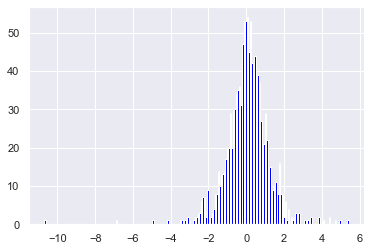

In [95]:
monte_carlo_results = sorted(portfolios, key=lambda x: float(x["Sharpe ratio"][:-1]) if type(x["Sharpe ratio"]) == str else x["Sharpe ratio"])[0]["Dataframe"]
monte_carlo_results["Portfolio Returns"].hist(bins=200, color="blue")

## Modern Portfolio Theory

### Mean-Variance (Markowitz Approach)

In [64]:
#Markowitz Model
number_of_random_portfolios = 1500

In [65]:
r_portfolio = df_returns_p[['LVMH Moët Hennessy Louis Vuitton S.E./MC.PA/Jewelry Stores', 'Sanofi/SAN.PA/Drug Manufacturers - Major', 'Eurofins Scientific SE/ERF.PA/Medical Laboratories & Research', 'Carrefour SA/CA.PA/Grocery Stores']]
r_portfolio

,LVMH Moët Hennessy Louis Vuitton S.E./MC.PA/Jewelry Stores,Sanofi/SAN.PA/Drug Manufacturers - Major,Eurofins Scientific SE/ERF.PA/Medical Laboratories & Research,Carrefour SA/CA.PA/Grocery Stores
Date,,,,
2018-06-21,-0.471139,-0.878354,2.312127,-1.383731
2018-06-22,0.771384,1.919972,0.235420,0.239570
2018-06-25,-2.957556,0.304300,-1.972770,-0.955968
2018-06-26,0.788833,-0.072241,8.145666,-1.378828
2018-06-27,0.836003,0.000000,7.443495,-1.607825
...,...,...,...,...
2023-06-13,0.850508,-1.147123,-0.033581,-0.854436
2023-06-14,0.962107,0.053234,1.142088,1.538935
2023-06-15,-0.741175,0.297934,0.232481,-1.060934


In [66]:
def sim_rand_portfolios(returns):

    mean_matrix = np.asmatrix(np.mean(returns, axis=0))
    weight_matrix = np.asmatrix(weighting_list(returns.T.shape[0]))
    cov_matrix = np.asmatrix(np.cov(returns.T))
    
    
    expected_return = weight_matrix * mean_matrix.T * 252
    volatility = np.sqrt(weight_matrix * cov_matrix * weight_matrix.T) * np.sqrt(252)
    
    # This recursion reduces outliers to keep plots pretty
    if volatility > 90:
        return sim_rand_portfolios(returns)
    return expected_return, volatility

means_return, vols = np.column_stack([
    sim_rand_portfolios(r_portfolio) 
    for _ in range(number_of_random_portfolios)
])

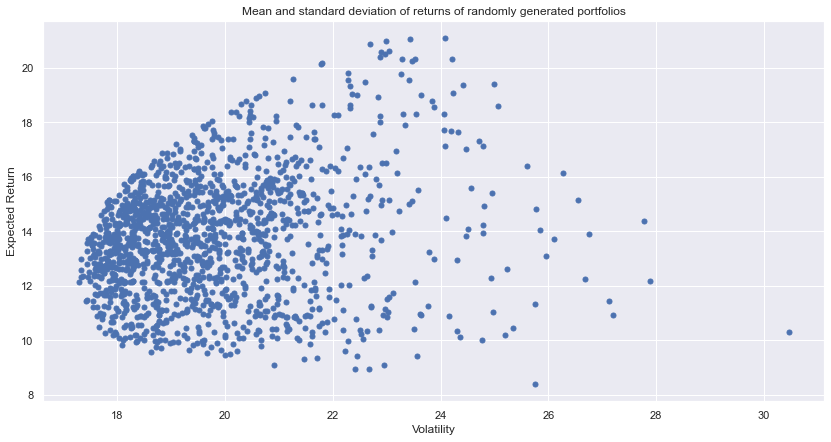

In [67]:
fig = plt.figure(figsize=(14, 7))
plt.plot(vols, means_return, 'o', markersize=5)
plt.xlabel('Volatility')
plt.ylabel('Expected Return')
plt.title('Mean and standard deviation of returns of randomly generated portfolios')
plt.show()

     pcost       dcost       gap    pres   dres
 0:  9.3444e-03 -1.4292e+00  1e+00  8e-17  3e+00
 1:  7.5283e-03 -3.8153e-02  5e-02  1e-16  9e-02
 2:  2.7907e-03 -6.5405e-04  3e-03  1e-16  4e-04
 3:  2.6548e-03  2.5844e-03  7e-05  8e-17  4e-06
 4:  2.6546e-03  2.6539e-03  7e-07  2e-16  4e-08
 5:  2.6546e-03  2.6546e-03  7e-09  1e-16  4e-10
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  1.4268e-01 -1.3581e+00  2e+00  7e-17  3e+00
 1:  1.3822e-01  6.0543e-02  8e-02  1e-16  1e-01
 2:  1.3486e-01  1.3299e-01  2e-03  2e-16  1e-04
 3:  1.3485e-01  1.3483e-01  2e-05  1e-16  1e-06
 4:  1.3485e-01  1.3485e-01  2e-07  1e-16  1e-08
 5:  1.3485e-01  1.3485e-01  2e-09  1e-16  1e-10
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  5.4760e-01 -1.0220e+00  2e+00  2e-16  3e+00
 1:  5.4089e-01  4.7076e-01  7e-02  1e-16  1e-01
 2:  5.3997e-01  5.3918e-01  8e-04  2e-16  1e-03
 3:  5.3997e-01  5.3996e-01  8e-06  2e-16  1e-05
 4:  5.3997e-01  5.3997e

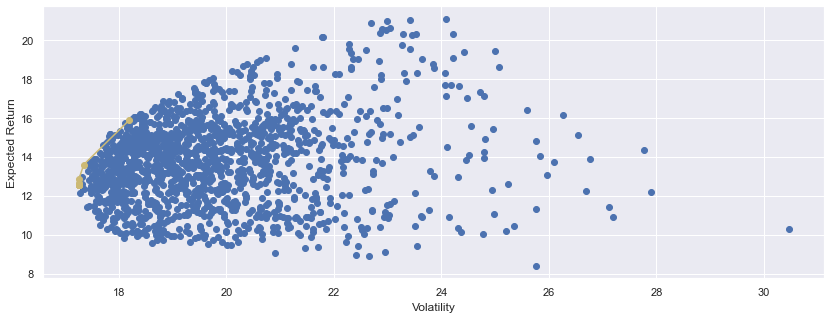

In [68]:
def sim_optimization_portfolio(returns):
    returns = returns.T
    n = len(returns)
    returns = np.asmatrix(returns)
    
    N = 10
    mus = [10**(5.0 * t/N - 1.0) for t in range(N)]
    
    S = opt.matrix(np.cov(returns))
    pbar = opt.matrix(np.mean(returns, axis=1))
    
    G = -opt.matrix(np.eye(n))  
    h = opt.matrix(0.1, (n ,1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)
    
    portfolios = [solvers.qp(mu*S, -pbar, G, h, A, b)['x'] 
                  for mu in mus]


    returns = [252*blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S*x))*np.sqrt(252) for x in portfolios]
    

    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])
    
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']
    return list(wt), returns, risks

weights, returns, risks = sim_optimization_portfolio(r_portfolio)

fig = plt.figure(figsize=(14,5))
plt.plot(vols, means_return, 'o')
plt.ylabel('Expected Return')
plt.xlabel('Volatility')
plt.plot(risks, returns, 'y-o')

In [69]:
mpt_results = list(zip(weights, r_portfolio.columns))
mpt_results

[(0.15265220076771585,
  'LVMH Moët Hennessy Louis Vuitton S.E./MC.PA/Jewelry Stores'),
 (0.4761581913143888, 'Sanofi/SAN.PA/Drug Manufacturers - Major'),
 (0.12375237144964213,
  'Eurofins Scientific SE/ERF.PA/Medical Laboratories & Research'),
 (0.24743723646825327, 'Carrefour SA/CA.PA/Grocery Stores')]

### Comparison

In [70]:
mpt_results = list(zip(weights, r_portfolio.columns))
mpt_results

[(0.15265220076771585,
  'LVMH Moët Hennessy Louis Vuitton S.E./MC.PA/Jewelry Stores'),
 (0.4761581913143888, 'Sanofi/SAN.PA/Drug Manufacturers - Major'),
 (0.12375237144964213,
  'Eurofins Scientific SE/ERF.PA/Medical Laboratories & Research'),
 (0.24743723646825327, 'Carrefour SA/CA.PA/Grocery Stores')]

In [71]:
monte_carlo_results = sorted(portfolios, key=lambda x: float(x["Sharpe ratio"][:-1]) if type(x["Sharpe ratio"]) == str else x["Sharpe ratio"])[0]["Combination"]
monte_carlo_results = [[float(elem.split('*')[0]), elem.split('*')[1]] for elem in monte_carlo_results.split("+")]
monte_carlo_results

[[0.13240696141830846, 'LVMH Moët Hennessy Louis Vuitton S.E. '],
 [0.36358155102059203, 'Sanofi '],
 [0.370639387445722, 'Carrefour SA '],
 [0.1333721001153775, 'Lagardère SCA']]

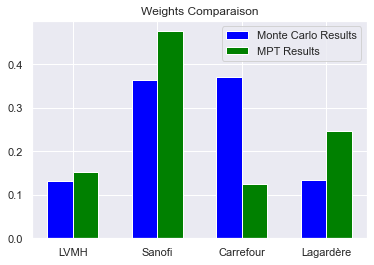

In [72]:
companies = [elem[1].split()[0] for elem in monte_carlo_results]
width = 3
x = np.array(list(range(1, len(companies)*10, 10)))
fig, ax = plt.subplots()
ax.bar(x - width/2, [elem[0] for elem in monte_carlo_results], width, color="blue", label="Monte Carlo Results")
ax.bar(x + width/2, [elem[0] for elem in mpt_results], width, color="green", label="MPT Results")
ax.set_xticks(x)
ax.set_xticklabels(companies)
ax.set_title("Weights Comparaison")
ax.legend()
plt.show()

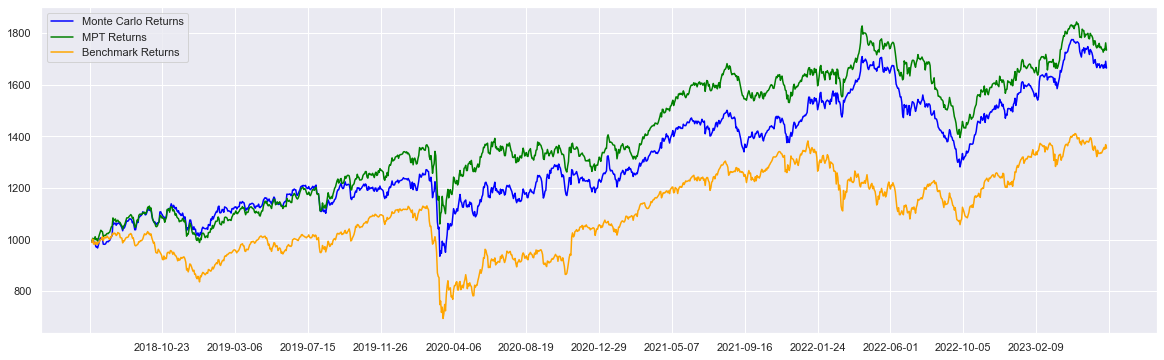

In [74]:
import matplotlib.dates as mdates

p_sh = sorted(portfolios, key=lambda x: float(x["Sharpe ratio"][:-1]) if type(x["Sharpe ratio"]) == str else x["Sharpe ratio"])[0]["Dataframe"]
returns_monte_carlo, index_returns = p_sh["Portfolio Returns"]/100, p_sh["Index Returns"]/100
capital_mpt, capital_monte, capital_index = 1000, 1000, 1000

returns_mpt = 0
ws_mpt = [elem[0] for elem in mpt_results] #Optimized Allocation
#ws_mpt = [0, 1, 0, 0] #Manual allocation
companies = [elem[1] for elem in mpt_results]
for w_mpt, stock in zip(ws_mpt, companies):
    returns_mpt += w_mpt/100*r_portfolio[stock]

r_monte_carlo = (1+returns_monte_carlo).to_list()
r_mpt = (1+returns_mpt).to_list()
r_index = (1+index_returns).to_list()

y_1, y_2, y_3 = [], [], []
for i in range(len(returns_monte_carlo)):
    res_mpt = capital_mpt * r_mpt[i]
    res_mont = capital_monte * r_monte_carlo[i]
    res_index = capital_index * r_index[i]
    y_1.append(res_mont)
    y_2.append(res_mpt)
    y_3.append(res_index)
    capital_mpt, capital_monte, capital_index = res_mpt, res_mont, res_index

dates = returns_monte_carlo.index
plt.figure(figsize=(20, 6))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=90))
plt.plot(dates, y_1, label="Monte Carlo Returns", color="blue")
plt.plot(dates, y_2, label="MPT Returns", color="green")
plt.plot(dates, y_3, label="Benchmark Returns", color="orange")
plt.legend()
plt.show()